# Glacier and ice sheet flow

<img src="Figures/MargerieGlacierPic.jpg" width=350 height=300 />
<center><i>Margerie glacier (Alaska)</i></center>

# Part 0: Information
This is the notebook associated with the lecture on Finite-Difference Methods for modeling ice sheet flow, which was presented by Vincent Verjans on November 21st 2022. 

The first part of the notebook is a summary of the derivations that we made in class. The second part of the notebook is the model code.

Feel free to use the code and play around with it. For example:
- Investigate issues of numerical stability. How do the time step and the spatial resolution affect the stability of the model? How can you relate the Courant–Friedrichs–Lewy condition to this problem?
- Vary the values of the ice rheology parameter (bigA in the code). Does it change the time needed to reach a steady-state? Does it affect the ice sheet profile?
- Change the accumulation rate (bdot in the code). Try to implement a space-dependent accumulation rate.
- Etc.

Any questions: vverjans3@gatech.edu

# Part 1: Derivation of the ice flow equation and Finite-Difference scheme

We consider the problem of the flow of ice. This first part of the notebook gives the derivation of the finite-difference scheme for simulating glacier flow. The details of the derivation are explained during the lecture, and on the whiteboard. For those of you who are interested in the derivation of the momentum equations, I recommend:
- "Fundamentals of glacier dynamics" by C. J. van der Veen

The essence of glacier flow physics lies in the notion of conservation of momentum: stresses acting on ice (gravity, friction with the bed, etc.) balance each other and cause ice deformation. The momentum conservation results in a complex system of equations: the "Stokes equations". But the system can be simplified to the "Shallow Ice Approximation" (SIA) if:
1. We use the hydrostatic approximation in the vertical (vertical stress varies much more along the vertical than horizontal direction)
2. We consider an ice mass along a flowline (2D) and neglect lateral forces
3. The ice is frozen to its bed (i.e., all the ice flow is due to deformation under gravitational forces)

The shear stress in the vertical reduces to:
$$
\tau_{xz}(z) = -\rho g (h-z) \frac{\partial h}{\partial x}
$$
where $g$ is gravity (9.81 m s<sup>-2</sup>), $\rho$ is the ice density ($\sim$ 917 kg m<sup>-3</sup>), $h$ is the ice thickness, $x$ is the horizontal coordinate, $z$ is the vertical coordinate. This is literally the force that shears the ice!
<div>
<img src="Figures/glacierSIAsketch.png" width="500"/>
</div>

The constitutive relation relates stress to deformation. In other words, it quantifies how much ice deforms under a given shear stres. Deformation is characterized by strain rates ($\epsilon$ $[$m s<sup>-1</sup>$]$)). Glacier ice is a visco-plastic material:
<div>
<img src="Figures/graphGlenGlowLaw.png" width="300"/>
</div>

This is known as Glen's flow law:
$$
\epsilon_{ij} = A \tau^{n-1} \tau_{ij}
$$
with $n\approx 3$ and $A$ depends on ice properties (temperature, fabrics, impurities ...). Note: here, we assume $A$ constant and set $A=3.5\times 10^{-24}$s<sup>-1</sup> Pa<sup>-3</sup>.

By definition:
$$
\epsilon_{xz} = \frac{1}{2}\left(\frac{\partial u}{\partial z}+\frac{\partial w}{\partial x}\right)
$$
where $u$ is the horizontal velocity and $w$ is the vertical velocity. Because of hydrostatic equilibrium, $\frac{\partial w}{\partial x} << \frac{\partial u}{\partial z}$. And $\epsilon_{xz}$ simplifies to:
$$
\epsilon_{xz} \approx \frac{1}{2}\frac{\partial u}{\partial z}
$$

Along a 2D flowline (in x-z dimensions), we have:
$$
\left\{
    \begin{array}\\
        \epsilon_{xz} = A \tau_{xz}^{n} \\ 
        \epsilon_{xz} = \frac{1}{2}\frac{\partial u}{\partial z} 
    \end{array}
\right.
$$

And thus:
$$
\frac{\partial u}{\partial z} = -2A\left[\rho g (h-z) \frac{\partial h}{\partial x}\right]^{n}
$$

Integrating and setting $u\left(z=0\right)=0$ (ice frozen to the bed):
$$
\int_{0}^{z} \frac{\partial u}{\partial z}\,dz = \int_{0}^{z} -2A\left[\rho g (h-z) \frac{\partial h}{\partial x}\right]^{n}\,dz 
$$
$$
\longrightarrow u(z) = \frac{2A\left(\rho g\right)^{n}}{n+1} \left(\frac{\partial h}{\partial x}\right)^{n} \left[\left(h-z\right)^{n+1}-h^{n+1}\right]
$$

Now, we want to find the depth-averaged velocity $\overline{u}$. Thus, we integrate a second time and we divide by the ice thickness ($h$).
$$
\frac{1}{h}\int_{0}^{z} u(z)\,dz = \frac{1}{h}\int_{0}^{z} \frac{2A\left(\rho g\right)^{n}}{n+1} \left(\frac{\partial h}{\partial x}\right)^{n} \left[\left(h-z\right)^{n+1}-h^{n+1}\right]\,dz 
$$
$$
\longrightarrow \overline{u} = \frac{-2A(\rho g)^{n}}{n+2}\left(\frac{\partial h}{\partial x}\right)^{n} h^{n+1}
$$

Now, we use the continuity equation. This equation ensures mass conservation. It stipulates that any change in ice column height must be balanced by a corresponding influx/outflux of ice and/or by a source term. The continuity equation is given by:
$$
\frac{\partial h}{\partial t} = \frac{-\partial}{\partial x}\left(\overline{u}h\right)+\dot{b}
$$

where $\dot{b}$ is the snowfall rate ($[$m s<sup>-1</sup>$]$). It thus represents a source term in our equation. This has the form of an advection equation. But notice that $\overline{u}$ depends on $h$. Thus, using the formulation derived for $\overline{u}$, the continuity equation can be re-written as a diffusion equation:
$$
\frac{\partial h}{\partial t} = \frac{\partial}{\partial x}\left(D \frac{\partial h}{\partial x}\right)+\dot{b}
$$

And the diffusion coefficient is:
$$
D = \frac{2A(\rho g)^{n}}{n+2}\left|\frac{\partial h}{\partial x}\right|^{n-1} h^{n+2}
$$

We evaluate our variable of interest on a discretized grid: ... $h_{i-2},\: h_{i-1},\: h_{i},\: h_{i+1},\: h_{i+2}$ ... (where $i$ is a space index)

But we evaluate the diffusion coefficients on a staggered grid: ... $D_{i-\frac{3}{2}},\: D_{i-\frac{1}{2}}, D_{i+\frac{1}{2}}, D_{i+\frac{3}{2}}$ ...

We write our system as a finite difference equation in a semi-implicit scheme:
$$
\frac{h_{i,t+1}-h_{i,t}}{\Delta t} = \frac{1}{\Delta x}\left(D_{i+\frac{1}{2}}\frac{h_{i+1,t+1}-h_{i,t+1}}{\Delta x}-D_{i-\frac{1}{2}}\frac{h_{i,t+1}-h_{i-1,t+1}}{\Delta x}\right) + \dot{b}_{i}
$$
Notice that this is semi-implicit because $D$ depends on $h_t$.

Setting all the $t+1$ terms on the left-hand-side:
$$
h_{i,t+1} - \frac{\Delta t}{(\Delta x)^2}\left[D_{i+\frac{1}{2}}\left(h_{i+1,t+1}-h_{i,t+1}\right)-D_{i-\frac{1}{2}}\left(h_{i,t+1}-h_{i-1,t+1}\right)\right] = h_{i,t}+\dot{b}_{i}\Delta t
$$

We re-write this equation as:
$$
-\alpha_{i} h_{i-1,t+1} + \beta_{i} h_{i,t+1} - \gamma_{i} h_{i+1,t+1} = \theta_{i}
$$
where:
$$
\alpha_i = \frac{\Delta t}{(\Delta x)^2} D_{i-\frac{1}{2}}
$$
$$
\beta_i =  1+\frac{\Delta t}{(\Delta x)^2} \left(D_{i-\frac{1}{2}}+D_{i+\frac{1}{2}}\right) 
$$
$$
\gamma_i = \frac{\Delta t}{(\Delta x)^2} D_{i+\frac{1}{2}} 
$$
$$
\theta_i = h_{i,t}+\dot{b}_{i}\Delta t
$$

And the full system can be written as a tridiagonal matrix system:
$$
\begin{bmatrix}
   \beta_1 & -\gamma_1 & 0 & 0 & 0 & ... & ... & ... & ...& 0 & 0 & 0 \\
   -\alpha_2 & \beta_2 & -\gamma_2 & 0 & 0 & ... & ... & ... & ...& 0 & 0 & 0 \\
   0 & -\alpha_3 & \beta_3 & -\gamma_3 & 0 & ... & ... & ... & ...& 0 & 0 & 0 \\
   . & . & . & . & ... & ... & ... & ... & ...& . & . & . \\
   0 & 0 & 0 & 0 & 0 & ... & ... & ... & ...& -\alpha_{n-1} & \beta_{n-1} & -\gamma_{n-1} \\
   0 & 0 & 0 & 0 & 0 & ... & ... & ... & ...& 0 & -\alpha_{n} & \beta_{n} \\
\end{bmatrix}
\begin{bmatrix}
    h_1 \\ h_2 \\ h_3 \\ . \\ h_{n-1} \\ h_{n}
\end{bmatrix}
= \begin{bmatrix}
    \theta_1 \\ \theta_2 \\ \theta_3 \\ . \\ \theta_{n-1} \\ \theta_{n} 
\end{bmatrix}
$$
We need to solve this sytem at each time step $t$ for the vector of unknown $h$.

First, we invert the coefficient matrix and solve for the $h_{t}$ vector. Then, we update the $\alpha, \beta, \gamma$ coefficients, because they depend on $D$, and thus on $h_{t}$. With the updated $h_{t}$ and $\alpha, \beta, \gamma$ coefficients, we solve for $h_{t+1}$ at the next time step. We proceed iteratively in this way.

What boundary conditions should we use? We can assume that the most upstream grid cell corresponds to an ice divide. An ice divide is the summit of an ice sheet, where the surface slope is 0. Thus, we enforce a Neumann boundary condition:
$$
h_1-h_2=0
$$
In the matrix equation, this translates to:
$$
\beta_1 = 1 
$$
$$
\gamma_1 = 1 
$$
$$
\theta_1 = 0
$$
At the end of the domain, we assume a strong ice removal mechanism, such that ice thickness is equal to 0. For example, the ice sheet can be assumed to reach the ocean at the end of the domain. Thus, we enforce a Dirichlet boundary condition:
$$
h_n=0
$$
In the matrix equation, this translates to:
$$
\beta_n = 1 
$$
$$
\alpha_n = 0 
$$
$$
\theta_n = 0
$$
Now, we are ready to code our finite-difference ice sheet model!

# Part 2: Example Code

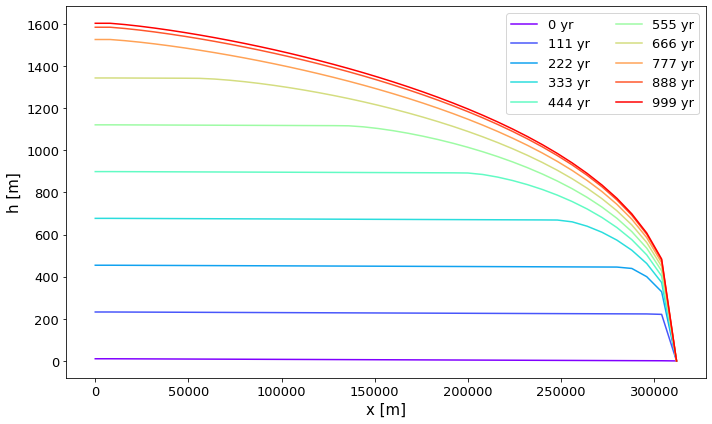

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

##### Set up the domain #####
nnx          = 40 #number of grid cells
deltax       = 8000.0 #distance between grid cells [m]
xgrid        = np.linspace(0,(nnx-1)*deltax,nnx) #grid in x-direction
nnt          = 4000 #number of time steps
deltatYr     = 0.5*0.5 #time step size in years
secpyr       = 365.25*24*3600 #number of seconds in one year
deltatSec    = deltatYr*secpyr #conversion to seconds
### Initialize the glacier ###
hvar         = np.array([np.linspace(10,0,nnx)]).T #from 10 to 0 m thickness (this only enforces small slope for numerical stability)
### Accumulation rate ###
bdotYr       = 2.0*np.ones((nnx,1)) #constant accumulation rate over the domain [m yr-1]
bdotSec      = bdotYr/secpyr #conversion to [m s-1]

##### Parameters #####
nGlen        = 3.0 #Glen exponent
bigA         = 3.5e-24 #ice rheology parameter [s-1 Pa-3]
rhoi         = 917.0 #ice density [kg m-3]
grv          = 9.81 #gravitational acceleration [m s-2]

##### Functions #####
def diffParamOnStaggeredGrid(hongrid,deltax,nGlen,bigA,rhoi,grv):
    '''
    Computes the diffusion coefficient on a staggered grid from the
    ice thickness values on the regular grid (hongrid)
    '''
    h_m   = hongrid[0:-1] #h at i indices
    h_p   = hongrid[1:] #h at i+1 indices
    dhdx  = (h_p-h_m)/deltax #evaluate gradient in h on the staggered grid (at i+1/2 indices)
    hstag = (h_m+h_p)/2 #average h between grid cells to get value on staggered grid (at i+1/2 indices)
    bigDstag = (2*bigA*(rhoi*grv)**nGlen)/(nGlen+2) * (abs(dhdx))**(nGlen-1) * hstag**(nGlen+2)
    return(bigDstag)
def getAlpha(bigDstag,deltax,deltat):
    alpha0 = (deltat/deltax**2)*bigDstag
    alpha  = np.append(0,alpha0) #first entry of alpha is a dummy value
    return(alpha)
def getGamma(bigDstag,deltax,deltat):
    gamma0 = (deltat/deltax**2)*bigDstag
    gamma  = np.append(gamma0,0)  #last entry of gamma is a dummy value
    return(gamma)
def getBeta(bigDstag,deltax,deltat):
    bigD_m = bigDstag[0:-1] #D at i-1/2 indices
    bigD_p = bigDstag[1:] #D at i+1/2 indices
    beta   = 1+(deltat/deltax**2)*(bigD_m+bigD_p)
    return(beta)

##### Choose plotting time steps #####
nplots    = 10 #number of time steps for plotting
StepsPlot = np.linspace(0,nnt-1,nplots).astype(int)
listPlot  = [] #list to save the h values at the time steps of StepsPlot

##### Loop over time steps #####
inith  = np.copy(hvar) #the initial condition
for tt in range(nnt):
    ### Get parameters ###
    bigD  = diffParamOnStaggeredGrid(hvar,deltax,nGlen,bigA,rhoi,grv)
    alpha = getAlpha(bigD,deltax,deltatSec)
    gamma = getGamma(bigD,deltax,deltatSec)
    beta0 = getBeta(bigD,deltax,deltatSec)
    ### Right-hand side source vector ###
    rhs   = hvar+(bdotSec*deltatSec)
    ### Boundary conditions ###
    beta      = np.append(np.append(1,beta0),1)
    alpha[-1] = 0
    gamma[0]  = 1
    rhs[0]    = 0
    rhs[-1]   = 0
    ### Construct matrices ###
    coefMat = diags(diagonals=[-1*alpha[1:],beta,-1*gamma[0:-1]],offsets=[-1,0,1]).toarray()
    ### Compute new h variable ###
    hvarnew = (np.linalg.inv(coefMat))@rhs #right-multiply by the inverse of coefMat
    hvar    = np.maximum(hvarnew,0) #remove negative ice thickness values
    ### Save for plotting ###
    if(tt in StepsPlot):
        listPlot.append(hvar)

##### Plotting #####
ls_cols = plt.cm.rainbow(np.linspace(0,1,len(StepsPlot)))
fig = plt.figure(figsize=[10,6])
ax  = plt.subplot(111)
for ii in range(len(StepsPlot)):
    ax.plot(xgrid,listPlot[ii],c=ls_cols[ii],label=f'{int(StepsPlot[ii]*deltatYr)} yr')
ax.tick_params(axis='both',which='major',labelsize=13)
ax.set_xlabel('x [m]',fontsize=15),ax.set_ylabel('h [m]',fontsize=15)
ax.legend(loc='best',ncol=2,fontsize=13)
fig.tight_layout()

    
    